In [48]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.circuit.library import UnitaryGate
from qiskit.result import marginal_counts
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import numpy as np

In [102]:
data, ancilla = QuantumRegister(9, 'Data'), QuantumRegister(6, 'Ancilla')
parity = [ClassicalRegister(2, f'X Parity Ancilla')]
parity += [ClassicalRegister(2, f'Z Parity Ancilla {i}') for i in range(3)]
observable = ClassicalRegister(1, name = 'Observable')

EPSILON = UnitaryGate([[1,0],
                     [0,1]], label = r'$\epsilon$')

$$\left| \bar{0} \right\rangle = |+\rangle \otimes |+\rangle \otimes |+\rangle = \frac{1}{2\sqrt{2}}\left( \left(|000\rangle + |111\rangle\right) \left(|000\rangle + |111\rangle\right) \left(|000\rangle + |111\rangle\right)  \right), $$
$$\left| \bar{1} \right\rangle = |-\rangle \otimes |-\rangle \otimes |-\rangle = \frac{1}{2\sqrt{2}}\left( \left(|000\rangle - |111\rangle\right) \left(|000\rangle - |111\rangle\right) \left(|000\rangle - |111\rangle\right)  \right)$$

In [145]:
encoder = QuantumCircuit(data)

# Phase-flip code
encoder.cx(0, 3)
encoder.cx(3, 6)
encoder.h(range(9)[::3])

# Concatenated bit-flip code
for j in range(9)[::3]:
     encoder.cx(j, j + 1)
     encoder.cx(j, j + 2)

In [135]:
error_channel = QuantumCircuit(data)
# Error channel
error_channel.barrier()
for i in data: error_channel.append(EPSILON, [i])

In [136]:
round = QuantumCircuit(data, ancilla, *parity)

# Disentangle bit-flip
for j in range(9)[::3]:
     round.cx(j, j + 2)
     round.cx(j, j + 1)
round.h(range(9)[::3])

# Parity check for phase
round.cx(0, 9)
round.cx(3, 9)
round.cx(3, 10)
round.cx(6, 10)

round.measure(ancilla[:2], parity[0])
round.reset(ancilla[:2])

# Recover phase
with round.switch(parity[0]) as case:
    with case(1): 
        round.z(0)
    with case(3): 
        round.z(3)
    with case(2): 
        round.z(6)


round.barrier()
# Reentangle bit-flip code
round.h(range(9)[::3])
for j in range(9)[::3]:
     round.cx(j, j + 1)
     round.cx(j, j + 2)

# Parity check and recover Z axis
for j,k, creg in zip(range(9)[::3], range(6)[::2], parity[1:]): 
     round.barrier()
     round.cx(data[j], ancilla[k])
     round.cx(data[j+1], ancilla[k])
     round.cx(data[j+1], ancilla[k+1])
     round.cx(data[j+2], ancilla[k+1])
     round.measure([ancilla[k], ancilla[k+1]], creg)
     round.reset([ancilla[k], ancilla[k+1]])
     with round.switch(creg) as case:
          with case(1): 
               round.x(data[j])
          with case(3): 
               round.x(data[j + 1])
          with case(2):
               round.x(data[j + 2])

#decoder.save_statevector()

In [137]:
# Decode and measure observable
decoder=QuantumCircuit(data, observable)
decoder.barrier()

for j in range(9)[::3]:
     decoder.cx(j, j + 1)
     decoder.cx(j, j + 2)

for j in range(8, 0, -3): decoder.ccx(j, j - 1, j - 2)

decoder.h(range(9)[::3])

decoder.cx(0, 3)
decoder.cx(0, 6)

decoder.ccx(6, 3, 0)

In [162]:
toy_error = QuantumCircuit(data)
toy_error.barrier()
toy_error.x(2)

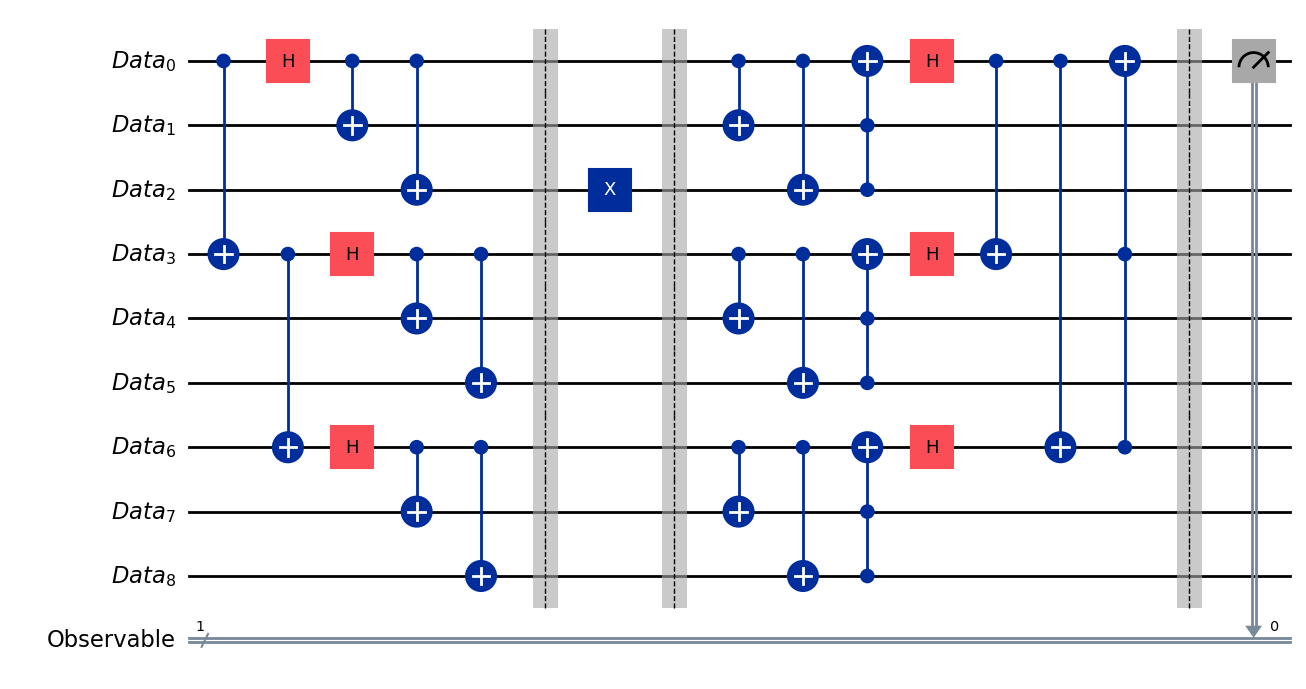

In [163]:
total_circ = QuantumCircuit(data, observable) 
total_circ &= encoder & toy_error & decoder

# Measure observable
total_circ.barrier()
total_circ.measure(0, observable)

total_circ.draw('mpl')

In [164]:
backend=AerSimulator(method = 'statevector', 
                    max_parallel_shots = 10, max_parallel_threads = 10)

backend.run(total_circ).result().get_counts()

{'0': 1024}

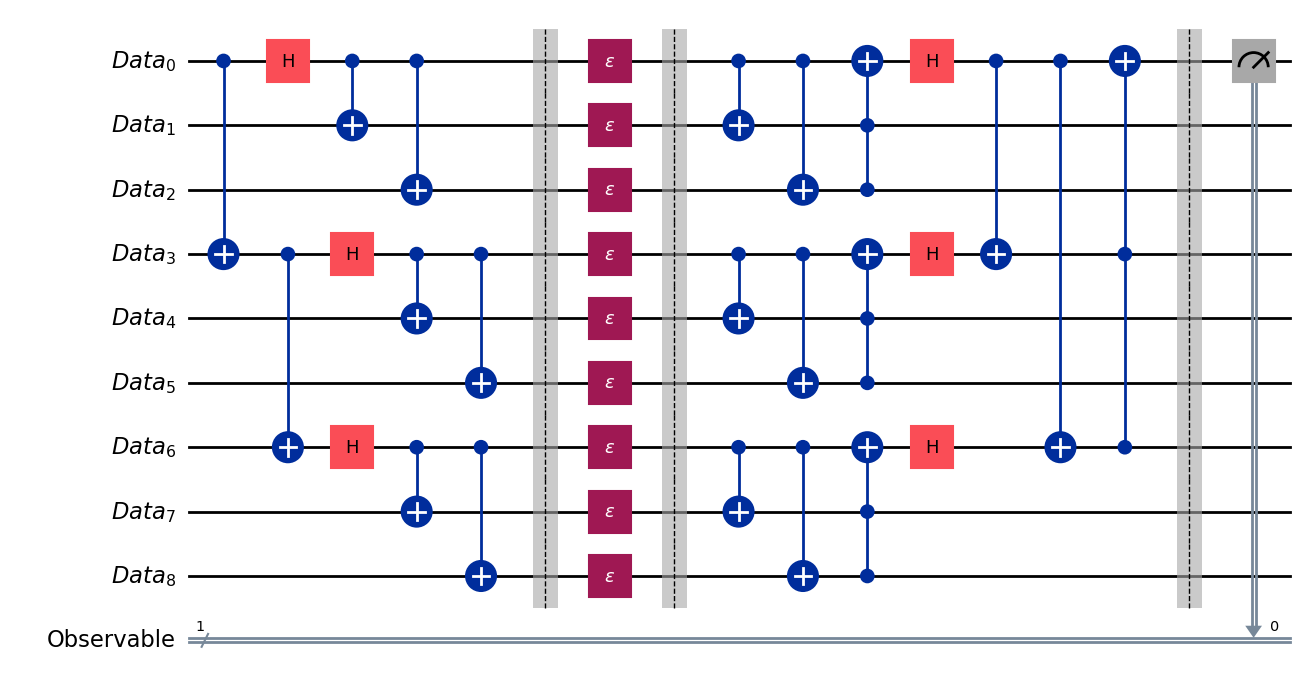

In [165]:
total_circ = QuantumCircuit(data, observable) 
total_circ &= encoder & error_channel & decoder

# Measure observable
total_circ.barrier()
total_circ.measure(0, observable)

total_circ.draw('mpl')

In [171]:
SHOTS = 2000
def config_backend(p_e):
    error = depolarizing_error(p_e, 1)
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error, [r'$\epsilon$'])
    noise_model.add_basis_gates(['unitary'])
    backend=AerSimulator(method = 'statevector', 
                        max_parallel_shots = 10, max_parallel_threads = 10, 
                        noise_model = noise_model, basis_gates = noise_model.basis_gates)
    return backend

backend = config_backend(1/10)

In [173]:
backend.run(total_circ, shots= SHOTS).result().get_counts()

{'1': 91, '0': 1909}

In [77]:
total_circ=encoder & (error_channel & round) & decoder
result=backend.run(total_circ, shots = 20).result().get_counts()
print('Syndrome Counts')
print(marginal_counts(result, range(8)))
logical_observable_counts = marginal_counts(result, [6])
print('\nObservable Counts')
print(logical_observable_counts)

Syndrome Counts
{'00000010': 1, '00000000': 19}

Observable Counts
{'0': 20}


In [66]:
total_circ.draw()

encode      ┌───┐                error channel »
          data_0: ───░──────■──┤ H ├──■────■──────────────░───────»
                     ░      │  └───┘┌─┴─┐  │              ░       »
          data_1: ───░──────┼───────┤ X ├──┼──────────────░───────»
                     ░      │       └───┘┌─┴─┐            ░       »
          data_2: ───░──────┼────────────┤ X ├────────────░───────»
                     ░    ┌─┴─┐     ┌───┐└───┘            ░       »
          data_3: ───░────┤ X ├──■──┤ H ├──■────■─────────░───────»
                     ░    └───┘  │  └───┘┌─┴─┐  │         ░       »
          data_4: ───░───────────┼───────┤ X ├──┼─────────░───────»
                     ░           │       └───┘┌─┴─┐       ░       »
          data_5: ───░───────────┼────────────┤ X ├───────░───────»
                     ░         ┌─┴─┐┌───┐     └───┘       ░       »
          data_6: ───░─────────┤ X ├┤ H ├──■────■─────────░───────»
                     ░         └───┘└───┘┌─┴─┐  │         ░       »
          data_7: ───░───────────────────┤ X ├──┼─────────░───────»
                     ░                   └───┘┌─┴─┐       ░       »
          data_8: ───░────────────────────────┤ X ├───────░───────»
                     ░                        └───┘       ░       »
       ancilla_0: ───░────────────────────────────────────░───────»
                     ░                                    ░       »
       ancilla_1: ───░────────────────────────────────────░───────»
                     ░                                    ░       »
       ancilla_2: ───░────────────────────────────────────░───────»
                     ░                                    ░       »
       ancilla_3: ───░────────────────────────────────────░───────»
                     ░                                    ░       »
       ancilla_4: ───░────────────────────────────────────░───────»
                     ░                                    ░       »
       ancilla_5: ───░────────────────────────────────────░───────»
                     ░                                    ░       »
ancilla_0 meas: 2/════════════════════════════════════════════════»
                                                                  »
ancilla_1 meas: 2/════════════════════════════════════════════════»
                                                                  »
ancilla_2 meas: 2/════════════════════════════════════════════════»
                                                                  »
ancilla_3 meas: 2/════════════════════════════════════════════════»
                                                                  »
    Observable: 1/════════════════════════════════════════════════»
                                                                  »
«                  ┌────────────┐ recover $X$           ┌───┐                  »
«          data_0: ┤ $\epsilon$ ├──────░────────■────■──┤ H ├──■───────────────»
«                  ├────────────┤      ░        │  ┌─┴─┐└───┘  │               »
«          data_1: ┤ $\epsilon$ ├──────░────────┼──┤ X ├───────┼───────────────»
«                  ├────────────┤      ░      ┌─┴─┐└───┘       │               »
«          data_2: ┤ $\epsilon$ ├──────░──────┤ X ├────────────┼───────────────»
«                  ├────────────┤      ░      └───┘     ┌───┐  │               »
«          data_3: ┤ $\epsilon$ ├──────░────────■────■──┤ H ├──┼────■────■─────»
«                  ├────────────┤      ░        │  ┌─┴─┐└───┘  │    │    │     »
«          data_4: ┤ $\epsilon$ ├──────░────────┼──┤ X ├───────┼────┼────┼─────»
«                  ├────────────┤      ░      ┌─┴─┐└───┘       │    │    │     »
«          data_5: ┤ $\epsilon$ ├──────░──────┤ X ├────────────┼────┼────┼─────»
«                  ├────────────┤      ░      └───┘     ┌───┐  │    │    │     »
«          data_6: ┤ $\epsilon$ ├──────░────────■────■──┤ H ├──┼────┼────┼─────»
«                  ├────────────┤      ░        │  ┌─┴─┐└───┘  │    │    │     »
«          data_

In [17]:
def shor_qec_protocol(backend: AerSimulator, 
                      psi: np.ndarray=np.array([1,0]), 
                      t: int=1, meas_basis: str='Z', shots: int=100):
    rounds=round.copy()
    for _ in range(t-1): 
        rounds &= round
    total_circ= QuantumCircuit(data, ancilla, *parity, observable)
    total_circ.initialize(psi, data[0])
    total_circ &= encoder & rounds & decoder
    
    match meas_basis:
        case 'X':
            total_circ.h(data[0])
        case 'Y':
            total_circ.h(data[0])
            total_circ.sdg(data[0])
        case 'Z':
            pass
    total_circ.measure(0, observable)
    
    result=backend.run(total_circ, shots=shots).result().get_counts()
    logical_observable_counts = marginal_counts(result, [6])
    return logical_observable_counts

def uncorrected_channel_protocol(backend: AerSimulator, 
                                 psi: np.ndarray=np.array([1,0]), 
                                 t: int=1, meas_basis: str='Z', shots: int=100):
    qc=QuantumCircuit(1, 1)
    qc.initialize(psi, 0)
    
    qc.append(EPSILON, [0])
    for _ in range(t-1):
        qc.append(EPSILON, [0])
    
    match meas_basis:
        case 'X':
            qc.h(0)
        case 'Y':
            qc.h(0)
            qc.sdg(0)
        case 'Z':
            pass
    qc.measure([0],[0])

    result = backend.run(qc, shots=shots).result().get_counts()
    physical_observable_counts = marginal_counts(result, [0])
    return physical_observable_counts

In [33]:
psi=np.array([0, 1])

shor_qec_protocol(config_backend(.01), psi, meas_basis='Z')

{'1': 100}

In [32]:
uncorrected_channel_protocol(config_backend(.01),  psi, meas_basis='Z')

{'0': 1, '1': 99}

In [21]:
epsilons=np.linspace(.01, .1, 5)
total=[]
for p in epsilons:
    total.append(shor_qec_protocol(config_backend(p), [0,1])['0']/SHOTS)

In [19]:
epsilons=np.linspace(.01, .1, 5)
logical_error_over_epsilons=Parallel(n_jobs=-1, verbose=11, backend='loky', batch_size=100)(
    delayed(lambda t: shor_qec_protocol(config_backend(epsilon))['0']/SHOTS)(epsilon) for epsilon in epsilons)

physical_error_over_epsilons=Parallel(n_jobs=-1, verbose=11, backend='loky', batch_size=100)(
    delayed(lambda t: uncorrected_channel_protocol(config_backend(epsilon))['0']/SHOTS)(epsilon) for epsilon in epsilons)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.0min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  2.0min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


In [ ]:
run_rounds=range(0,15,5)
logical_survival_over_rounds=Parallel(n_jobs=-1, verbose=11, 
                                      backend='loky', batch_size=100)(delayed(lambda t: shor_qec_protocol(backend, t))(t) for t in run_rounds)

physical_survival_over_rounds=Parallel(n_jobs=-1, verbose=11, 
                                       backend='loky', batch_size=100)(delayed(lambda t: uncorrected_channel_protocol(backend, t))(t) for t in run_rounds)


In [43]:
list(range(4))[1:]

[1, 2, 3]

In [ ]:
xs=range(len(run_rounds))
plt.plot(xs, logical_survival_over_rounds)
plt.scatter(xs, logical_survival_over_rounds)
plt.plot(xs, physical_survival_over_rounds)
plt.scatter(xs, physical_survival_over_rounds)

In [74]:
x=0
for _ in range(2):
    x+=1
    print(_)

0
1


In [143]:
list(run_rounds)

[0, 5, 10, 15, 20, 25]